In [22]:
# Purpose: Import required libraries for forecasting

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Literal

# Forecasting
from prophet import Prophet

# Metrics for validation
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Plotting (optional, for inspection only)
import matplotlib.pyplot as plt

import logging

logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)

In [23]:
# Purpose: Load the global weekly dataset

DATA_DIR = Path("../data/streamlit")
INPUT_FILE = DATA_DIR / "global_trend_summary.csv"

df_global = pd.read_csv(INPUT_FILE)

# Ensure proper types
df_global["date"] = pd.to_datetime(df_global["date"])
df_global["keyword"] = df_global["keyword"].str.lower().str.strip()
df_global["search_interest"] = pd.to_numeric(df_global["search_interest"], errors="coerce")

df_global.head()

,date,keyword,search_interest
0,2020-09-13,breathwork,1
1,2020-09-13,guided meditation,6
2,2020-09-13,meditation,93
3,2020-09-13,mindfulness,25
4,2020-09-13,yoga nidra,3


In [24]:
# Purpose: Helper to prepare a single-keyword time series for Prophet

def prepare_for_prophet(df: pd.DataFrame, keyword: str) -> pd.DataFrame:
    """
    Prepare a single-keyword weekly time series for Prophet.

    Parameters
    ----------
    df : pd.DataFrame
        Input with columns ['date', 'keyword', 'interest'].
    keyword : str
        Keyword to filter on (case-insensitive).

    Returns
    -------
    pd.DataFrame
        Columns ['ds', 'y'] sorted by 'ds' (datetime), ready for Prophet.

    Raises
    ------
    ValueError
        If required columns are missing, the keyword is not present,
        or the series contains missing values.
    """
    required = {"date", "keyword", "search_interest"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    kw = keyword.strip().lower()
    s = df.loc[df["keyword"].str.lower().eq(kw), ["date", "search_interest"]].copy()

    if s.empty:
        available = sorted(df["keyword"].str.lower().unique().tolist())
        raise ValueError(f"Keyword '{kw}' not found. Available: {available}")

    if s["search_interest"].isna().any() or s["date"].isna().any():
        raise ValueError("Found NaNs in 'date' or 'interest' for the selected keyword.")

    s = s.rename(columns={"date": "ds", "search_interest": "y"}).sort_values("ds").reset_index(drop=True)

    # Prophet expects numeric y; enforce dtype explicitly.
    s["y"] = pd.to_numeric(s["y"], errors="raise")

    return s

In [25]:
# Example (inspection only):
meditation_ts = prepare_for_prophet(df_global, "meditation")
meditation_ts.head()

,ds,y
0,2020-09-13,93
1,2020-09-20,92
2,2020-09-27,91
3,2020-10-04,93
4,2020-10-11,87


In [26]:
# Purpose: Fit Prophet for one keyword and generate a forward forecast

def forecast_keyword(
    df: pd.DataFrame,
    keyword: str,
    periods: int,
    freq: str = "W",
    weekly_seasonality: bool = True,
    yearly_seasonality: bool = True,
) -> pd.DataFrame:
    """
    Fit a Prophet model for a single keyword and forecast forward.

    Parameters
    ----------
    df : pd.DataFrame
        Input with columns ['date', 'keyword', 'interest'].
    keyword : str
        Keyword to filter on.
    periods : int
        Number of future periods to forecast (in 'freq' units).
    freq : str, default "W"
        Pandas frequency string for future periods (weekly here).
    weekly_seasonality : bool, default True
        Whether to include weekly seasonality.
    yearly_seasonality : bool, default True
        Whether to include yearly seasonality.

    Returns
    -------
    pd.DataFrame
        Forecast with columns ['ds','yhat','yhat_lower','yhat_upper','keyword'].
    """
    ts = prepare_for_prophet(df, keyword)

    model = Prophet(
        weekly_seasonality=False,
        yearly_seasonality=yearly_seasonality,
        daily_seasonality=False,
    )
    model.fit(ts)

    future = model.make_future_dataframe(periods=periods, freq=freq)
    fcst = model.predict(future)

    out = fcst[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
    out["keyword"] = keyword
    return out


In [27]:
# Purpose: Run forecasts for all keywords and combine into one DataFrame

KEYWORDS = ["meditation", "mindfulness", "breathwork", "guided meditation", "yoga nidra"]

# Forecast horizons
HORIZON_12W = 12   # near-term
HORIZON_52W = 52   # long-term

# Collect forecasts
forecasts_12w = []
forecasts_52w = []

for kw in KEYWORDS:
    fc12 = forecast_keyword(df_global, kw, periods=HORIZON_12W)
    fc52 = forecast_keyword(df_global, kw, periods=HORIZON_52W)
    forecasts_12w.append(fc12)
    forecasts_52w.append(fc52)

df_fc12 = pd.concat(forecasts_12w).reset_index(drop=True)
df_fc52 = pd.concat(forecasts_52w).reset_index(drop=True)

df_fc12.head(), df_fc52.head()


(          ds       yhat  yhat_lower  yhat_upper     keyword
 0 2020-09-13  88.584134   83.734676   93.415534  meditation
 1 2020-09-20  89.759436   84.591703   94.280514  meditation
 2 2020-09-27  90.467236   85.700025   95.042050  meditation
 3 2020-10-04  89.721210   84.874337   94.328217  meditation
 4 2020-10-11  87.839384   83.000362   92.546752  meditation,
           ds       yhat  yhat_lower  yhat_upper     keyword
 0 2020-09-13  88.584134   83.629982   93.116967  meditation
 1 2020-09-20  89.759436   84.865899   94.428102  meditation
 2 2020-09-27  90.467236   85.819622   95.065283  meditation
 3 2020-10-04  89.721210   85.239303   94.547341  meditation
 4 2020-10-11  87.839384   83.000952   92.416937  meditation)

In [28]:
# Purpose: Backtest Prophet by holding out the last N weeks per keyword

def backtest_keyword(df: pd.DataFrame, keyword: str, holdout_weeks: int = 26) -> dict:
    """
    Hold out the last `holdout_weeks` points, fit on the rest, and evaluate MAPE/RMSE.

    Parameters
    ----------
    df : pd.DataFrame
        Input with columns ['date', 'keyword', 'interest'].
    keyword : str
        Keyword to test.
    holdout_weeks : int
        Number of weeks to hold out for evaluation.

    Returns
    -------
    dict
        {'keyword': str, 'mape': float, 'rmse': float, 'train_points': int, 'test_points': int}
    """
    ts = prepare_for_prophet(df, keyword)
    if len(ts) <= holdout_weeks + 10:
        raise ValueError(f"Series for '{keyword}' is too short for a {holdout_weeks}-week holdout.")

    train = ts.iloc[:-holdout_weeks].copy()
    test = ts.iloc[-holdout_weeks:].copy()

    model = Prophet(weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)
    model.fit(train)

    future = model.make_future_dataframe(periods=holdout_weeks, freq="W")
    pred = model.predict(future).iloc[-holdout_weeks:][["ds", "yhat"]].reset_index(drop=True)

    mape = mean_absolute_percentage_error(test["y"].to_numpy(), pred["yhat"].to_numpy())
    rmse = np.sqrt(mean_squared_error(test["y"].to_numpy(), pred["yhat"].to_numpy()))

    return {
        "keyword": keyword,
        "mape": float(mape),
        "rmse": float(rmse),
        "train_points": int(len(train)),
        "test_points": int(len(test)),
    }

# Run backtests for all keywords
KEYWORDS = ["meditation", "mindfulness", "breathwork", "guided meditation", "yoga nidra"]
bt_results = [backtest_keyword(df_global, kw, holdout_weeks=26) for kw in KEYWORDS]
pd.DataFrame(bt_results).sort_values("mape")


,keyword,mape,rmse,train_points,test_points
4,yoga nidra,0.038477,0.195066,236,26
2,breathwork,0.100430,0.689487,236,26
0,meditation,0.101932,11.368641,236,26
1,mindfulness,0.152848,5.437204,236,26
3,guided meditation,0.179057,1.335515,236,26


In [29]:
# Purpose: Generate final 12-week and 52-week forecasts for all keywords

HORIZON_12W = 12
HORIZON_52W = 52

def build_all_forecasts(df: pd.DataFrame, keywords: list, horizon: int) -> pd.DataFrame:
    """
    Generate forecasts for all keywords and combine into one DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset with columns ['date','keyword','interest'].
    keywords : list
        Keywords to forecast.
    horizon : int
        Forecast horizon in weeks.

    Returns
    -------
    pd.DataFrame
        Combined forecasts with columns ['ds','yhat','yhat_lower','yhat_upper','keyword'].
    """
    results = []
    for kw in keywords:
        fc = forecast_keyword(df, kw, periods=horizon)
        results.append(fc)
    return pd.concat(results).reset_index(drop=True)

df_fc12 = build_all_forecasts(df_global, KEYWORDS, HORIZON_12W)
df_fc52 = build_all_forecasts(df_global, KEYWORDS, HORIZON_52W)

df_fc12.head(), df_fc52.head()


(          ds       yhat  yhat_lower  yhat_upper     keyword
 0 2020-09-13  88.584134   84.023872   93.380585  meditation
 1 2020-09-20  89.759436   85.256015   94.436326  meditation
 2 2020-09-27  90.467236   85.842861   95.109154  meditation
 3 2020-10-04  89.721210   84.627412   94.531305  meditation
 4 2020-10-11  87.839384   82.808802   92.383582  meditation,
           ds       yhat  yhat_lower  yhat_upper     keyword
 0 2020-09-13  88.584134   83.761316   93.434652  meditation
 1 2020-09-20  89.759436   85.054794   94.574748  meditation
 2 2020-09-27  90.467236   85.478919   95.097807  meditation
 3 2020-10-04  89.721210   84.711715   93.881857  meditation
 4 2020-10-11  87.839384   82.757158   92.484469  meditation)

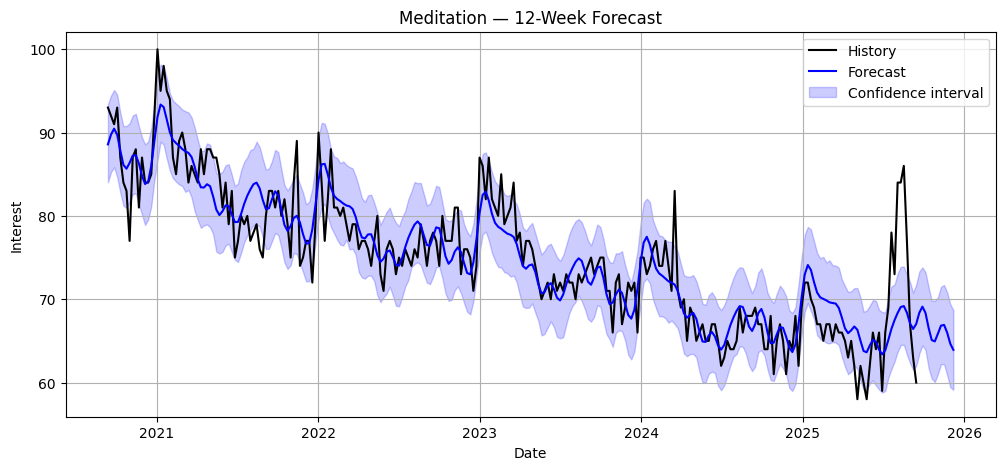

In [30]:
# Purpose: Plot historical data with forecast for one keyword

def plot_forecast(df: pd.DataFrame, df_forecast: pd.DataFrame, keyword: str, horizon: int) -> None:
    """
    Plot historical values and forecast with uncertainty intervals.

    Parameters
    ----------
    df : pd.DataFrame
        Original dataset with ['date','keyword','interest'].
    df_forecast : pd.DataFrame
        Forecasted values with ['ds','yhat','yhat_lower','yhat_upper','keyword'].
    keyword : str
        Keyword to plot.
    horizon : int
        Forecast horizon (for labeling).
    """
    hist = df[df["keyword"] == keyword]
    fc = df_forecast[df_forecast["keyword"] == keyword]

    plt.figure(figsize=(12, 5))
    plt.plot(hist["date"], hist["search_interest"], label="History", color="black")
    plt.plot(fc["ds"], fc["yhat"], label="Forecast", color="blue")
    plt.fill_between(fc["ds"], fc["yhat_lower"], fc["yhat_upper"], color="blue", alpha=0.2, label="Confidence interval")

    plt.title(f"{keyword.title()} — {horizon}-Week Forecast")
    plt.xlabel("Date")
    plt.ylabel("Interest")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_forecast(df_global, df_fc12, "meditation", 12)


In [19]:
# Purpose: Summarize last forecasted value per keyword

def summarize_forecasts(df_forecast: pd.DataFrame, horizon: int) -> pd.DataFrame:
    """
    Summarize the final forecasted point for each keyword.

    Parameters
    ----------
    df_forecast : pd.DataFrame
        Forecast results with ['ds','yhat','yhat_lower','yhat_upper','keyword'].
    horizon : int
        Horizon length (for labeling).

    Returns
    -------
    pd.DataFrame
        One row per keyword with last forecasted date and values.
    """
    summary = (
        df_forecast.groupby("keyword")
        .tail(1)[["keyword", "ds", "yhat", "yhat_lower", "yhat_upper"]]
        .rename(columns={"ds": "forecast_date"})
    )
    summary["horizon"] = horizon
    return summary.reset_index(drop=True)

summary_12w = summarize_forecasts(df_fc12, 12)
summary_52w = summarize_forecasts(df_fc52, 52)

summary_12w, summary_52w


(             keyword forecast_date       yhat  yhat_lower  yhat_upper  horizon
 0         meditation    2025-12-07  64.005854   59.128190   68.779173       12
 1        mindfulness    2025-12-07  20.072878   17.737386   22.281897       12
 2         breathwork    2025-12-07   3.475009    3.075947    3.897310       12
 3  guided meditation    2025-12-07   3.324891    2.781817    3.850114       12
 4         yoga nidra    2025-12-07   2.863136    2.418796    3.283741       12,
              keyword forecast_date       yhat  yhat_lower  yhat_upper  horizon
 0         meditation    2026-09-13  67.244757   62.450777   72.375042       52
 1        mindfulness    2026-09-13  23.273685   20.929289   25.483469       52
 2         breathwork    2026-09-13   3.951485    3.544006    4.397860       52
 3  guided meditation    2026-09-13   3.842218    3.321370    4.351514       52
 4         yoga nidra    2026-09-13   3.068060    2.617327    3.461205       52)